# Basic RNN - Recurrent Neural Networks

Up to now we've used neural networks to classify static images. What happens when the thing we're trying to
explain changes over time? What if a predicted value depends on a series of past behaviors?
We can train networks to tell us that an image contains a car.
How do we answer the question "Is the car moving? Where will it be a minute from now?"
This challenge of incorporating a series of measurements over time into the model parameters is addressed by
Recurrent Neural Networks (RNNs).

Be sure to watch the theory lectures. You should be comfortable with:

* conditional memory
* deep sequence modeling
* vanishing gradients
* gated cells
* long short-term memory (LSTM) cells

PyTorch offers a number of RNN layers and options.

torch.nn.RNN() provides a basic model which applies a multilayer RNN with either tanh or ReLU nonlinearity functions to an input sequence.
As we learned in the theory lectures, however, this has its limits.

torch.nn.LSTM() adds a multi-layer long short-term memory (LSTM) process which greatly extends the
memory of the RNN.

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

### Creating a simple sine wave dataset

For this exercise we'll look at a simple sine wave. We'll take 800 data points and assign 40 points per full cycle,
for a total of 20 complete cycles. We'll train our model on all but the last cycle, and use that to evaluate our test
predictions.

In [4]:
x = torch.linspace(0,799,800)


In [5]:
y= torch.sin(x*2*3.1416/40)

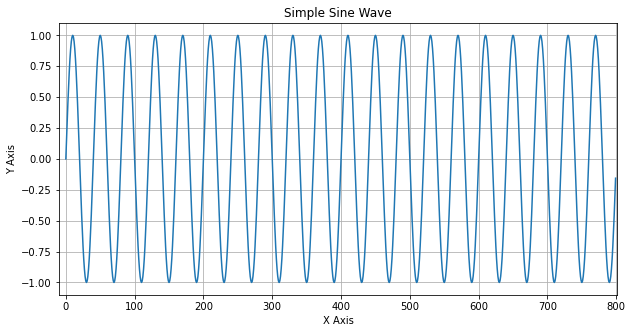

In [6]:
plt.figure(figsize=(10,5))
plt.xlim(-10,801) # setting the x limit
plt.grid(True)
plt.plot(y.numpy())# converting torch to numpy array
plt.title('Simple Sine Wave')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()

### Create train and test sets

We want to take the first 760 samples in our series as a training sequence, and the last 40 for testing.

*NOTE:* We tend to use the terms "series" and "sequence" interchangeably. Usually "series" refers to the

In [7]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size]

### Prepare the training data

When working with LSTM models, we start by dividing the training sequence into a series of overlapping
"windows". Each window consists of a connected string of samples. The label used for comparison is equal to
the next value in the sequence. In this way our network learns what value should follow a given pattern of
preceding values. Note: although the LSTM layer produces a prediction for each sample in the window, we only
care about the last one.

For example, say we have a series of 15 records, and a window size of 5. We feed into the model, and
compare the prediction to . Then we backprop, update parameters, and feed into the model. We
compare the new output to and so forth up to .

To simplify matters, we'll define a function called input_data that builds a list of (seq, label) tuples.
Windows overlap, so the first tuple might contain , the second would have , etc.
Here is the width of the window. Due to the overlap, we'll have a total number of (seq, label) tuples equal
to

[x1 ,..,x5 ]
x6 [x2 ,..,x6 ]
x7 [x10,..,x14]
([x1 ,..,x5 ],
[x6 ])
([x2 ,..,x6 ],
[x7 ])
k
len(series)
− k

In [8]:
def input_data(seq, ws):
    out = []
    L=len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out    

*NOTE:* "Windows" are different from "batches". In our example we'll feed one window into the model at a
time, so our batch size would be 1. If we passed two windows into the model before we backprop and
update weights, our batch size would be 2.

To train on our sine wave data we'll use a window size of 40 (one entire cycle).

In [9]:
window_size = 40
# Creat the training dataset of sequence/label tuples:
train_data = input_data(train_set, window_size)
len(train_data) # this must be equal to 760-40

720

In [10]:
# display the first seq/label tuple in train_data
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [11]:
# improve the appearance of tensors
torch.set_printoptions(sci_mode=False) 
train_data[0]

(tensor([     0.0000,      0.1564,      0.3090,      0.4540,      0.5878,
              0.7071,      0.8090,      0.8910,      0.9511,      0.9877,
              1.0000,      0.9877,      0.9511,      0.8910,      0.8090,
              0.7071,      0.5878,      0.4540,      0.3090,      0.1564,
             -0.0000,     -0.1564,     -0.3090,     -0.4540,     -0.5878,
             -0.7071,     -0.8090,     -0.8910,     -0.9511,     -0.9877,
             -1.0000,     -0.9877,     -0.9511,     -0.8910,     -0.8090,
             -0.7071,     -0.5878,     -0.4540,     -0.3090,     -0.1564]),
 tensor([    0.0000]))

### Define an LSTM model

Our model will have one LSTM layer with an input size of 1 and a hidden size of 50, followed by a fully-connected
layer to reduce the output to the prediction size of 1.

NOTE: You will often see the terms input_dim and hidden_dim used in place of input_size and hidden_size.
They mean the same thing. We'll stick to input_size and hidden_size to stay consistent with PyTorch's builtin keywords.

During training we pass three tensors through the LSTM layer - the sequence, the hidden state and the cell
state .

This means we need to initialize and . This can be done with random values, but we'll use zeros instead.

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size)
        # Add a fully connected layer:
        self.linear = nn.Linear(hidden_size, out_size)
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),
                      torch.zeros(1,1,hidden_size))
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1),self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1] # we only care about last prediction

### Instantiate the model, define loss & optimization functions

Since we're comparing single values, we'll use torch.nn.MSELoss
Also, we've found that torch.optim.SGD converges faster for this application than torch.optim.Adam

In [18]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [19]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

Count the model parameters

In [21]:
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


### Predicting future values

To show how an LSTM model improves after each epoch, we'll run predictions and plot the results. Our goal is to
predict the last sequence of 40 values, and compare them to the known data in our test set. However, we have
to be careful not to use test data in the predictions - that is, each new prediction derives from previously
predicted values.

The trick is to take the last known window, predict the next value, then append the predicted value to the
sequence and run a new prediction on a window that includes the value we've just predicted. It's like adding
track in front of the train as it's moving.
Image source: https://giphy.com/gifs/aardman-cartoon-train-3oz8xtBx06mcZWoNJm
Wallace & Gromit
In this way, a well-trained model should follow any regular trends/cycles in the data.


In this way, a well-trained model should follow any regular trends/cycles in the data.

### Train and simultaneously evaluate the model

We'll train 10 epochs. For clarity, we'll "zoom in" on the test set, and only display from point 700 to the end.

Epoch:  1 Loss: 0.08211267
Loss on test predictions: 0.5918405055999756


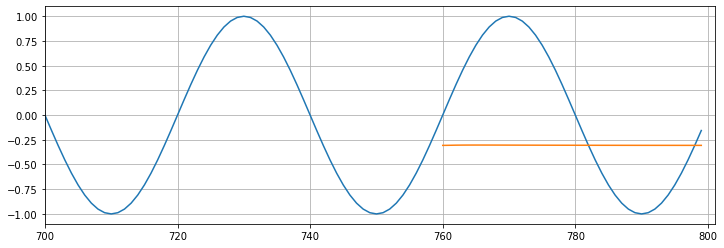

Epoch:  2 Loss: 0.05738069
Loss on test predictions: 0.5518227815628052


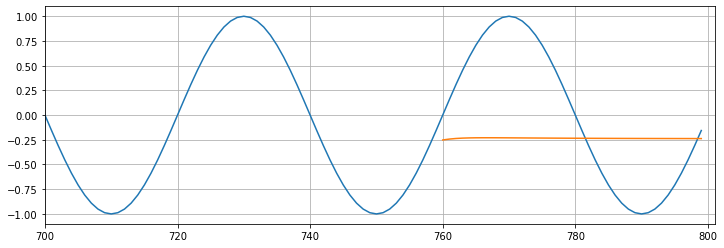

Epoch:  3 Loss: 0.03391115
Loss on test predictions: 0.49785155057907104


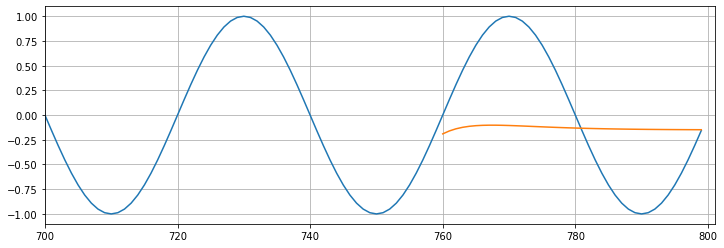

In [23]:
epochs = 3
future = 40

for i in range(epochs):
    
    # tuple-unpack the train_data set
    for seq, y_train in train_data:
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
       # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')

    # MAKE PREDICTIONS
        # start with a list of the last 10 training records
    preds = train_set[-window_size:].tolist()
    
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

### Forecasting into an unknown future

We'll continue to train our model, this time using the entire dataset. Then we'll predict what the next 40 points
should be.

### Train the model

Expect this to take a few minutes.